<a href="https://colab.research.google.com/github/rahulhalderAERO/Hydrodynamic_LSTM_ROM/blob/main/hydrodynamic_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The LSTM-PINN algorithms introduces the loss function computed from the discretized governing equation.The Governing Equation is the rigid body dynamic Equation as 
\begin{align}
        [M]\ddot{x}  = F \\
\end{align}
where, 
\begin{align}
        [M] = 
\begin{bmatrix}
M & 0 & 0\\
0 & M & 0\\
0 & 0 & J
\end{bmatrix} ,
[X] = 
\begin{bmatrix}
S \\
h \\
\alpha
\end{bmatrix} ,
[F] = 
\begin{bmatrix}
F_x \\
F_y + (1-1/{\rho}_r)Mg \\
T
\end{bmatrix}
\end{align}

The Governing Equations can be written as sets of first order derivatives:

\begin{align}
̇\begin{bmatrix}
X \\
\dot{X} 
\end{bmatrix} +
\begin{bmatrix}
0 & 0 & 0 & -1 & 0 & 0\\
0 & 0 & 0 & 0 & -1 & 0\\
0 & 0 & 0 & 0 & 0 & -1\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
X \\
\dot{X} 
\end{bmatrix} = 
\begin{bmatrix}
0 \\
0 \\
0 \\
M^{-1} F 
\end{bmatrix}
\end{align}

This set of Equations are implemented in the PINN_Loss class
        


In [ ]:
from keras.models import Sequential 
from keras.layers import Dense
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from keras import backend as K
import tensorflow as tf
import random
import time
start_time = time.time()
Ext_Col = 6
test_step = 25

Import Training and Test Data

In [ ]:
Output_Train = pd.read_csv("https://raw.githubusercontent.com/rahulhalderAERO/Hydrodynamic_LSTM_ROM/main/LSTM_PINN_Data/box_smooth_Dis.csv",skiprows = None , header = None )
Input_Train = pd.read_csv("https://raw.githubusercontent.com/rahulhalderAERO/Hydrodynamic_LSTM_ROM/main/LSTM_PINN_Data/Test_Input_Force_Only.csv",skiprows = None , header = None )
Output_Test = pd.read_csv("https://raw.githubusercontent.com/rahulhalderAERO/Hydrodynamic_LSTM_ROM/main/LSTM_PINN_Data/box_smooth_Dis.csv",skiprows = None , header = None )
Input_Test = pd.read_csv("https://raw.githubusercontent.com/rahulhalderAERO/Hydrodynamic_LSTM_ROM/main/LSTM_PINN_Data/Test_Input_Force_Only.csv",skiprows = None , header = None )

`Normalize the input data`

In [ ]:
Output_array = Output_Train.values
Input_array_Dis = Input_Train.values
input_scaler = MinMaxScaler(feature_range=(0, 1))
input_Traindata = input_scaler.fit_transform(Input_Train)
input_Testdata = input_scaler.fit_transform(Input_Test)

**initialize** output with zero


In [ ]:
output_discrete = np.zeros(shape=(Output_array.shape[0],Output_array.shape[1]+Ext_Col*2))
x_train = []
y_train = []
x_test = []

Prepare the input train dataset with the windows of time

In [ ]:
for i in range(test_step,input_Traindata.shape[0]):
    x_train.append(input_Traindata[i-test_step:i,0].reshape(-1,1))
x_train_mid = np.array(x_train)
x_train = []

for j in range(2,4):
    for i in range(test_step,input_Traindata.shape[0]):
        x_train.append(input_Traindata[i-test_step:i,j].reshape(-1,1))
    x_train_mid1 = np.array(x_train)
    x_train = []
    x_train_final = np.concatenate((x_train_mid,x_train_mid1),axis = 2) 
    x_train_mid = x_train_final
    
x_train = x_train_final

Prepare the input test dataset with the windows of time


In [ ]:
for i in range(test_step,input_Testdata.shape[0]):
    x_test.append(input_Testdata[i-test_step:i,0].reshape(-1,1))
x_test_mid = np.array(x_test)
x_test = []

for j in range(2,4):
    for i in range(test_step,input_Testdata.shape[0]):
        x_test.append(input_Testdata[i-test_step:i,j].reshape(-1,1))
    x_test_mid1 = np.array(x_test)
    x_test = []
    x_test_final = np.concatenate((x_test_mid,x_test_mid1),axis = 2) 
    x_test_mid = x_test_final
    
x_test = x_test_final

The output of the LSTM-PINN network contains the box responses and their time derivatives at $n^{th}$ ,$n^{th}-1 $ and $n^{th}-2$  time steps. Therefore the size of the output of the network is $R^{18\times N_{t}}$ . $n$ is any time instant in total time steps of $N_{t}$. 

In [ ]:
for j in range(Ext_Col):
    output_discrete[:,3*(j)] = Output_array[:,j]
    output_discrete[1:,3*(j)+1] = Output_array[:-1,j]
    output_discrete[2:,3*(j)+2] = Output_array[:-2:,j]
output_final =  np.concatenate((output_discrete,Input_array_Dis[:,1:4]),axis=1)


output_scaler = MinMaxScaler(feature_range=(0, 1))
output_Traindata = output_scaler.fit_transform(output_final)


y_train = output_Traindata[test_step:len(output_final)]

For the LSTM-PINN network, a percentage of the training input is considered. Zero is inserted in the rows where data are not available.  

In [ ]:
list=[]
for i in range(10200):
    r=random.randint(1,y_train.shape[0]-1)
    if r not in list: list.append(r)
    list_array = np.array(list)


for k in range(len(list_array)):
    val_row = list_array[k]
    y_train[val_row,:-3] = 0

LSTM Model


In [ ]:
model = Sequential()
model.add(LSTM(units = 50,return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))    
model.add(LSTM(units =50,return_sequences = True))
model.add(LSTM(units = 50))
model.add(Dense(units = 21))

The PINN loss function PINN_LOSS is designed in such a way, The data based loss function and governing equation based loss function is computed for the input and output rows and only governing equation based loss function is computed for the rows where data is not available. Function **DIFF_FILTERED** is formulated as following: 
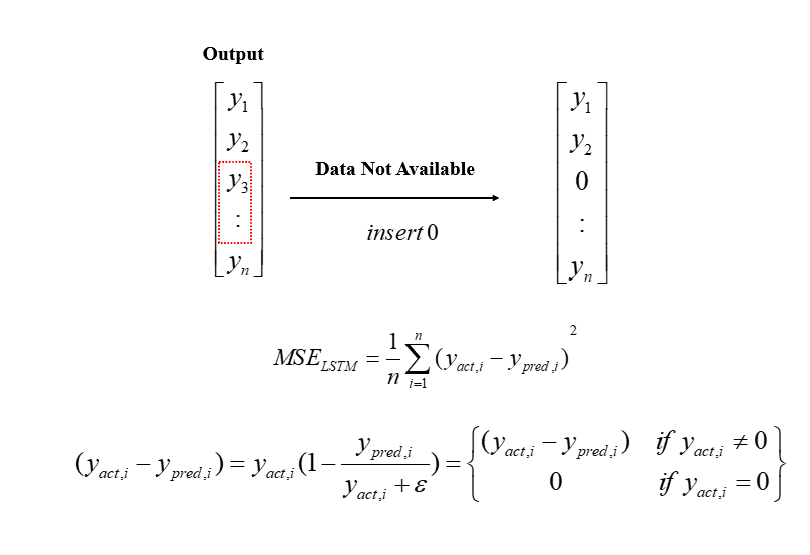

In [ ]:
dt = 0.008;


def normalized_to_actual(pred,i):
    min_pred =  output_final[:,i].min()
    max_pred =  output_final[:,i].max()
    return (max_pred-min_pred)*pred[:,i]+min_pred

def actual_to_normalized(y,i):
    min_pred =  output_final[:,i].min()
    max_pred =  output_final[:,i].max()
    return (y-min_pred)/(max_pred-min_pred)



def PINN_LOSS(y_true, y_pred):
        
    def DIFF_FILTERED(x, y):
        y_true_new = x+0.00001
        y_true_div = tf.math.divide(y, y_true_new)
        difference = 1-y_true_div
        y_true_mult = tf.math.multiply(x, difference)
        return y_true_mult
    
    loss_mid = (K.square(DIFF_FILTERED(y_true[:,0], y_pred[:,0])))
    w = [1,0.01,0.01,0.01,0.001,0.001,0.001] # Weight matrix for the loss functions
    
    for i in range(1,17):
        loss_mid = loss_mid + (K.square(DIFF_FILTERED(y_true[:,i], y_pred[:,i]))) 
    
    # velocity and acceleration computed from the predicted results. 

    v_x = (3*normalized_to_actual(y_pred,0)-4*normalized_to_actual(y_pred,1) + normalized_to_actual(y_pred,2))/(2*dt)
    v_y = (3*normalized_to_actual(y_pred,3)-4*normalized_to_actual(y_pred,4) + normalized_to_actual(y_pred,5))/(2*dt)
    v_th =(3*normalized_to_actual(y_pred,6)-4*normalized_to_actual(y_pred,7) + normalized_to_actual(y_pred,8))/(2*dt)
    
    a_x = (3*normalized_to_actual(y_pred,9)-4*normalized_to_actual(y_pred,10) + normalized_to_actual(y_pred,11))/(2*dt)
    a_y = (3*normalized_to_actual(y_pred,12)-4*normalized_to_actual(y_pred,13) + normalized_to_actual(y_pred,14))/(2*dt)
    a_th =(3*normalized_to_actual(y_pred,15)-4*normalized_to_actual(y_pred,16) + normalized_to_actual(y_pred,17))/(2*dt)
    
    Act_vs = actual_to_normalized(v_x,9)
    Act_vh = actual_to_normalized(v_y,12)
    Act_vth =actual_to_normalized(v_th,15)
    
    Act_as = actual_to_normalized(a_x,18)
    Act_ah = actual_to_normalized(a_y,19)
    Act_ath = actual_to_normalized(a_th,20)
    
    loss_accsurge = (K.square(y_true[:,18]-Act_as))
    loss_accheave = (K.square(y_true[:,19]-Act_ah))
    loss_accpitch = (K.square(y_true[:,20]-Act_ath))
    
    loss_velsurge = (K.square(y_true[:,9]-Act_vs))
    loss_velheave = (K.square(y_true[:,12]-Act_vh))
    loss_velpitch = (K.square(y_true[:,15]-Act_vth))
    
    # loss_mid is data based loss function and loss_accsurge, loss_accheave, loss_accpitch are the losses computed from the acceleration equations. 
    # loss_velsurge, loss_velheave, loss_velpitch are loss based on the velocity equation. 
    
    loss_mid2 = w[0]*loss_mid + w[1]*loss_accsurge + w[2]*loss_accheave + w[3]*loss_accpitch + w[4]*loss_velsurge + w[5]*loss_velheave + w[6]*loss_velpitch 
    
    loss = K.mean((loss_mid2),axis = -1)
    return loss

Train and prediction Phase

In [ ]:
epochs = 500
model.compile(optimizer = 'adam' , loss = PINN_LOSS)
history = model.fit(x_train,y_train, epochs = epochs , batch_size = 25)
A = history.history['loss']
print("--- %s seconds ---" % (time.time() - start_time))
predicted_y = (model.predict(x_train))
y_pred_trainset_inv = output_scaler.inverse_transform(predicted_y)

Epoch 1/500
80/80 [==============================] - 9s 24ms/step - loss: 0.0733
Epoch 2/500
80/80 [==============================] - 2s 23ms/step - loss: 0.0157
Epoch 3/500
80/80 [==============================] - 2s 24ms/step - loss: 0.0147
Epoch 4/500
80/80 [==============================] - 2s 24ms/step - loss: 0.0136
Epoch 5/500
80/80 [==============================] - 2s 24ms/step - loss: 0.0122
Epoch 6/500
80/80 [==============================] - 2s 23ms/step - loss: 0.0116
Epoch 7/500
80/80 [==============================] - 2s 23ms/step - loss: 0.0111
Epoch 8/500
80/80 [==============================] - 2s 23ms/step - loss: 0.0085
Epoch 9/500
80/80 [==============================] - 2s 23ms/step - loss: 0.0043
Epoch 10/500
80/80 [==============================] - 2s 23ms/step - loss: 0.0038
Epoch 11/500
80/80 [==============================] - 2s 23ms/step - loss: 0.0037
Epoch 12/500
80/80 [==============================] - 3s 33ms/step - loss: 0.0038
Epoch 13/500
80/80 [=====

plot

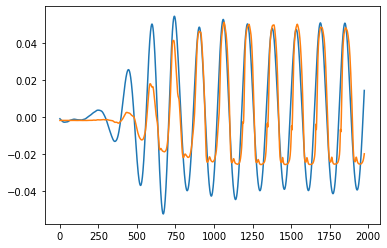

In [ ]:
plt.plot(np.arange(0,len(y_train)),Output_array[test_step:,1],label='Actual')
plt.plot(np.arange(0,len(y_train)),y_pred_trainset_inv[:,3] , label ='Predicted')